# Image Generation with Microsoft Foundry

> **Utility Notebook** - This notebook generates mascot images for the Foundry Workshop documentation. It is not a tutorial on deploying image models.

In this notebook, we'll use Microsoft Foundry's **gpt-image-1.5** model to generate custom Promptling mascot images.

## Prerequisites

Before running this notebook, ensure you have:

| Requirement | Description |
|-------------|-------------|
| **gpt-image-1.5 deployed** | Image generation model must already be deployed in your Foundry project |
| **`.env` file configured** | Must contain `FOUNDRY_IMAGE_ENDPOINT`, `FOUNDRY_API_KEY`, and `IMAGE_MODEL_DEPLOYMENT` |

> **Need to deploy the image model?** See [Deploy Azure OpenAI image generation models](https://learn.microsoft.com/azure/ai-services/openai/how-to/dall-e) for step-by-step instructions.

## What You'll Learn
- How to call the Foundry Image Generation API
- Generate images with **transparent backgrounds**
- Batch process multiple prompts
- Resize images for different use cases

---

## Step 1: Setup & Configuration

First, let's install dependencies and load our environment variables.

In [ ]:
# Install required packages
%pip install requests pillow python-dotenv --quiet

In [ ]:
import os
import base64
import requests
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
from IPython.display import display, Markdown

# Load environment variables
load_dotenv()

# Configuration
endpoint = os.getenv("FOUNDRY_IMAGE_ENDPOINT")
api_key = os.getenv("FOUNDRY_API_KEY")
deployment_name = os.getenv("IMAGE_MODEL_DEPLOYMENT", "gpt-image-1.5")

# Verify configuration
if not endpoint or not api_key:
    raise ValueError("Missing FOUNDRY_IMAGE_ENDPOINT or FOUNDRY_API_KEY in .env file")

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

print(f"Endpoint: {endpoint[:50]}...")
print(f"Model: {deployment_name}")

## Step 2: Define Image Prompts

We'll generate a series of **Promptling** mascot images - a cute blue space-suited character representing different workshop concepts.

Each prompt follows a consistent style:
- Anime style illustration with clean line art
- Transparent background
- Consistent character design across all images

In [3]:
# Image prompts with metadata for organization
PROMPTS = [
    {
        "name": "00_command_center",
        "title": "The Foundry Command Center (Hero Image)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background, isolated complex scene.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling floating happily in front of a large, curved holographic control console.
The console glows with blue light and has many buttons and sliders.
The Promptling is actively pressing buttons.
Surrounding the central console are four smaller, floating holographic displays connected by glowing lines:
1. Top left display shows a small rocket taking off.
2. Top right display shows a glowing shield icon.
3. Bottom left display shows a brain icon with sparks.
4. Bottom right display shows a magnifying glass over a document.
The overall mood is busy, high-tech, and cheerful."""
    },
    {
        "name": "01_architect",
        "title": "The Architect (Foundry Overview)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background, isolated characters only.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling holding a rolled-up blueprint under one arm.
The Promptling is giving a confident thumbs up.
Simple, clean, heroic pose."""
    },
    {
        "name": "02_hub_spoke",
        "title": "The Hub & Spoke (Architecture)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background, isolated objects only.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One large central glowing sphere.
Three smaller spheres orbiting it.
One Promptling floating above them, pointing at the center sphere."""
    },
    {
        "name": "03_foundation",
        "title": "Lab 1a: The Foundation (Landing Zone)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling planting a flag into a simple gray moon surface.
The flag has a gear icon on it.
Victorious and steady pose."""
    },
    {
        "name": "04_connection",
        "title": "Lab 1b: The Connection (Project Spoke)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling holding a large oversized power plug.
The Promptling is walking towards a floating socket outlet.
Determined expression."""
    },
    {
        "name": "05_traffic_control",
        "title": "Lab 1c: Traffic Control (Model Router)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling wearing a traffic warden sash.
Pointing a small paper plane to the left.
Pointing a large rocket ship to the right."""
    },
    {
        "name": "06_scaling_up",
        "title": "Lab 2a: Scaling Up (Team Spokes)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
Three Promptlings floating in a circle holding hands.
They are surrounding a central glowing light.
Teamwork and harmony."""
    },
    {
        "name": "07_legacy_line",
        "title": "Lab 2b: Legacy Line (Direct APIM)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling speaking into a tin can phone.
A string connects the tin can to a floating server block.
Simple and retro vibe."""
    },
    {
        "name": "08_guard",
        "title": "Lab 3a: The Guard (Governance Policy)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling holding a glowing holographic shield.
The Promptling is making a \"stop\" hand gesture gently.
Safe and protected atmosphere."""
    },
    {
        "name": "09_container",
        "title": "Lab 4a: The Container (Hosted Agents)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling pushing a shipping container.
The container is blue and simple.
Exerting effort but smiling."""
    },
    {
        "name": "10_brain",
        "title": "Lab 5: The Brain (Agent Memory)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling tapping the side of its helmet.
A lightbulb icon is floating above its head.
Smart and thoughtful pose."""
    },
    {
        "name": "11_detective",
        "title": "Lab 6: The Detective (Foundry IQ)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling holding a large magnifying glass.
Looking closely at a floating open book.
Curious and focused."""
    },
    {
        "name": "12_mechanic",
        "title": "Lab 7a: The Mechanic (Built-in Tools)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling floating with a tool belt.
Holding a wrench in one hand and a document in the other.
Ready to work."""
    },
    {
        "name": "13_connector",
        "title": "Lab 7b: The Connector (MCP Integration)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling connecting two puzzle pieces together.
One piece is blue, one piece is green.
They fit perfectly."""
    },
    {
        "name": "14_telescope",
        "title": "Lab 7c: The Telescope (Web Search)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling looking through a telescope.
A tiny satellite is visible in the distance.
Discovery and observation."""
    },
    {
        "name": "15_scholar",
        "title": "Lab 8: The Scholar (Deep Research)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling sitting on a stack of books.
Reading a large open document with intensity.
Surrounded by floating papers."""
    },
    {
        "name": "16_scanner",
        "title": "Lab 9: The Scanner (Content Understanding)",
        "prompt": """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling holding a handheld scanner device.
Scanning a floating film reel.
A green checkmark appears above the scanner."""
    }
]

print(f"Loaded {len(PROMPTS)} image prompts")
for i, p in enumerate(PROMPTS):
    print(f"   {i+1}. {p['title']}")

Loaded 17 image prompts
   1. The Foundry Command Center (Hero Image)
   2. The Architect (Foundry Overview)
   3. The Hub & Spoke (Architecture)
   4. Lab 1a: The Foundation (Landing Zone)
   5. Lab 1b: The Connection (Project Spoke)
   6. Lab 1c: Traffic Control (Model Router)
   7. Lab 2a: Scaling Up (Team Spokes)
   8. Lab 2b: Legacy Line (Direct APIM)
   9. Lab 3a: The Guard (Governance Policy)
   10. Lab 4a: The Container (Hosted Agents)
   11. Lab 5: The Brain (Agent Memory)
   12. Lab 6: The Detective (Foundry IQ)
   13. Lab 7a: The Mechanic (Built-in Tools)
   14. Lab 7b: The Connector (MCP Integration)
   15. Lab 7c: The Telescope (Web Search)
   16. Lab 8: The Scholar (Deep Research)
   17. Lab 9: The Scanner (Content Understanding)


## Step 3: Image Generation Function

This function calls the Microsoft Foundry Image Generation API with:
- **Transparent background** for clean mascot images
- **PNG format** to preserve transparency
- **1024x1024** resolution

In [4]:
def generate_image(prompt: str) -> bytes | None:
    """
    Generate an image using Microsoft Foundry's gpt-image-1.5 model.
    
    Args:
        prompt: The text description of the image to generate
        
    Returns:
        Image bytes if successful, None otherwise
    """
    payload = {
        "prompt": prompt,
        "model": deployment_name,
        "size": "1024x1024",
        "quality": "medium",
        "output_format": "png",
        "output_compression": 100,
        "background": "transparent",  # Key setting for transparent PNGs
        "n": 1
    }
    
    try:
        response = requests.post(endpoint, headers=headers, json=payload, timeout=120)
        response.raise_for_status()
        
        data = response.json()
        b64_json = data.get("data", [{}])[0].get("b64_json")
        
        if b64_json:
            return base64.b64decode(b64_json)
        else:
            print("Warning: No image data in response")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"API Error: {e}")
        return None


def resize_image(image_bytes: bytes, size: tuple = (256, 256)) -> bytes:
    """
    Resize an image while preserving transparency.
    
    Args:
        image_bytes: Original image as bytes
        size: Target size as (width, height)
        
    Returns:
        Resized image as bytes
    """
    with Image.open(BytesIO(image_bytes)) as img:
        img_resized = img.resize(size, Image.Resampling.LANCZOS)
        output = BytesIO()
        img_resized.save(output, format="PNG")
        return output.getvalue()


def display_image(image_bytes: bytes, title: str = ""):
    """
    Display an image in the notebook with optional title.
    """
    if title:
        display(Markdown(f"### {title}"))
    img = Image.open(BytesIO(image_bytes))
    display(img)


print("Functions defined")

Functions defined


## Step 4: Generate All Images

Now let's generate all the Promptling images! Each image will be:
1. Generated at 1024x1024 with transparent background
2. Saved to the `assets/` folder
3. Resized to 256x256 for thumbnails
4. Displayed in the notebook

> **Note:** Each image takes ~30-60 seconds to generate

Starting generation of 17 images...


[1/17] The Foundry Command Center (Hero Image)
----------------------------------------
   Saved: assets/00_command_center_1024.png
   Saved: assets/00_command_center_256.png
   Generated in 24.2s


### The Foundry Command Center (Hero Image)

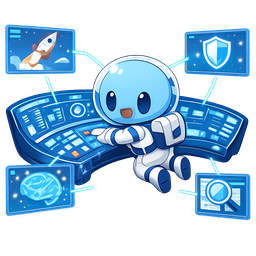


[2/17] The Architect (Foundry Overview)
----------------------------------------
   Saved: assets/01_architect_1024.png
   Saved: assets/01_architect_256.png
   Generated in 20.3s


### The Architect (Foundry Overview)

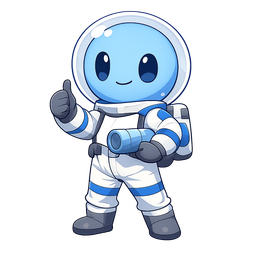


[3/17] The Hub & Spoke (Architecture)
----------------------------------------
   Saved: assets/02_hub_spoke_1024.png
   Saved: assets/02_hub_spoke_256.png
   Generated in 23.4s


### The Hub & Spoke (Architecture)

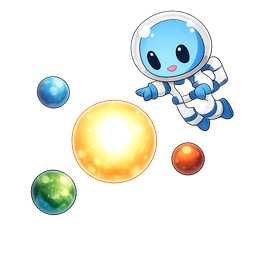


[4/17] Lab 1a: The Foundation (Landing Zone)
----------------------------------------
   Saved: assets/03_foundation_1024.png
   Saved: assets/03_foundation_256.png
   Generated in 22.6s


### Lab 1a: The Foundation (Landing Zone)

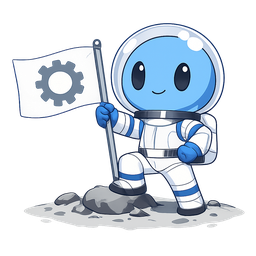


[5/17] Lab 1b: The Connection (Project Spoke)
----------------------------------------
   Saved: assets/04_connection_1024.png
   Saved: assets/04_connection_256.png
   Generated in 24.0s


### Lab 1b: The Connection (Project Spoke)

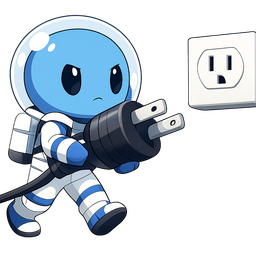


[6/17] Lab 1c: Traffic Control (Model Router)
----------------------------------------
   Saved: assets/05_traffic_control_1024.png
   Saved: assets/05_traffic_control_256.png
   Generated in 21.4s


### Lab 1c: Traffic Control (Model Router)

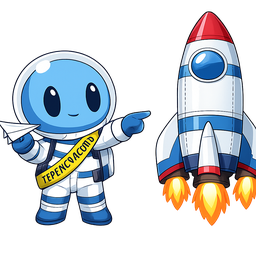


[7/17] Lab 2a: Scaling Up (Team Spokes)
----------------------------------------
   Saved: assets/06_scaling_up_1024.png
   Saved: assets/06_scaling_up_256.png
   Generated in 21.6s


### Lab 2a: Scaling Up (Team Spokes)

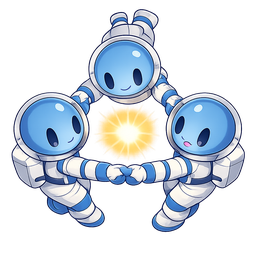


[8/17] Lab 2b: Legacy Line (Direct APIM)
----------------------------------------
   Saved: assets/07_legacy_line_1024.png
   Saved: assets/07_legacy_line_256.png
   Generated in 22.4s


### Lab 2b: Legacy Line (Direct APIM)

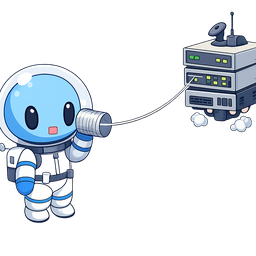


[9/17] Lab 3a: The Guard (Governance Policy)
----------------------------------------
   Saved: assets/08_guard_1024.png
   Saved: assets/08_guard_256.png
   Generated in 22.2s


### Lab 3a: The Guard (Governance Policy)

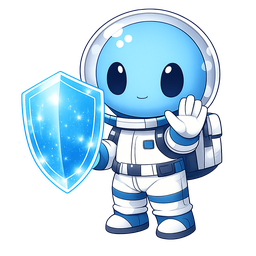


[10/17] Lab 4a: The Container (Hosted Agents)
----------------------------------------
   Saved: assets/09_container_1024.png
   Saved: assets/09_container_256.png
   Generated in 24.6s


### Lab 4a: The Container (Hosted Agents)

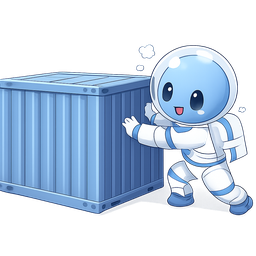


[11/17] Lab 5: The Brain (Agent Memory)
----------------------------------------
   Saved: assets/10_brain_1024.png
   Saved: assets/10_brain_256.png
   Generated in 21.1s


### Lab 5: The Brain (Agent Memory)

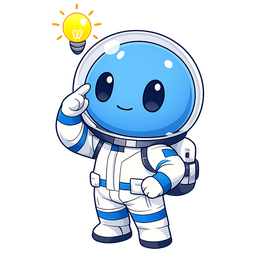


[12/17] Lab 6: The Detective (Foundry IQ)
----------------------------------------
   Saved: assets/11_detective_1024.png
   Saved: assets/11_detective_256.png
   Generated in 22.6s


### Lab 6: The Detective (Foundry IQ)

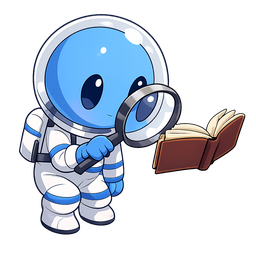


[13/17] Lab 7a: The Mechanic (Built-in Tools)
----------------------------------------
   Saved: assets/12_mechanic_1024.png
   Saved: assets/12_mechanic_256.png
   Generated in 23.6s


### Lab 7a: The Mechanic (Built-in Tools)

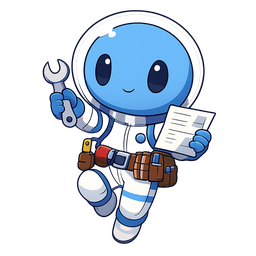


[14/17] Lab 7b: The Connector (MCP Integration)
----------------------------------------
   Saved: assets/13_connector_1024.png
   Saved: assets/13_connector_256.png
   Generated in 21.9s


### Lab 7b: The Connector (MCP Integration)

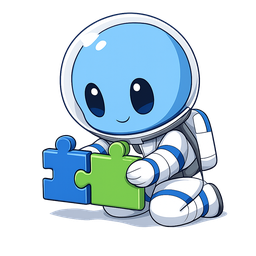


[15/17] Lab 7c: The Telescope (Web Search)
----------------------------------------
   Saved: assets/14_telescope_1024.png
   Saved: assets/14_telescope_256.png
   Generated in 23.9s


### Lab 7c: The Telescope (Web Search)

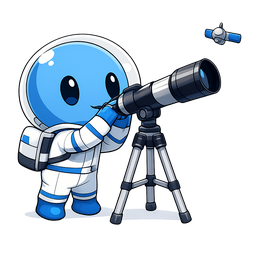


[16/17] Lab 8: The Scholar (Deep Research)
----------------------------------------
   Saved: assets/15_scholar_1024.png
   Saved: assets/15_scholar_256.png
   Generated in 29.2s


### Lab 8: The Scholar (Deep Research)

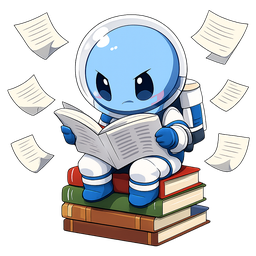


[17/17] Lab 9: The Scanner (Content Understanding)
----------------------------------------
   Saved: assets/16_scanner_1024.png
   Saved: assets/16_scanner_256.png
   Generated in 24.2s


### Lab 9: The Scanner (Content Understanding)

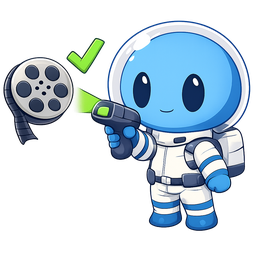


Generation complete!


In [5]:
import time

# Create output directory
OUTPUT_DIR = "assets"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Track results
results = []

print(f"Starting generation of {len(PROMPTS)} images...\n")
print("=" * 60)

for i, item in enumerate(PROMPTS):
    name = item["name"]
    title = item["title"]
    prompt = item["prompt"]
    
    print(f"\n[{i+1}/{len(PROMPTS)}] {title}")
    print("-" * 40)
    
    start_time = time.time()
    
    # Generate image
    image_bytes = generate_image(prompt)
    
    if image_bytes:
        elapsed = time.time() - start_time
        
        # Save original (1024x1024)
        original_path = os.path.join(OUTPUT_DIR, f"{name}_1024.png")
        with open(original_path, "wb") as f:
            f.write(image_bytes)
        print(f"   Saved: {original_path}")
        
        # Resize and save thumbnail (256x256)
        thumbnail_bytes = resize_image(image_bytes, (256, 256))
        thumbnail_path = os.path.join(OUTPUT_DIR, f"{name}_256.png")
        with open(thumbnail_path, "wb") as f:
            f.write(thumbnail_bytes)
        print(f"   Saved: {thumbnail_path}")
        
        print(f"   Generated in {elapsed:.1f}s")
        
        # Display the image
        display_image(thumbnail_bytes, title)
        
        results.append({"name": name, "title": title, "status": "Success", "time": f"{elapsed:.1f}s"})
    else:
        print(f"   Failed to generate")
        results.append({"name": name, "title": title, "status": "Failed", "time": "-"})

print("\n" + "=" * 60)
print("Generation complete!")

## Step 5: Summary Report

Let's review what was generated:

In [6]:
import pandas as pd

# Create summary table
df = pd.DataFrame(results)
df.index = df.index + 1
df.index.name = "#"

# Count successes
success_count = len([r for r in results if "Success" in r["status"]])
total_count = len(results)

display(Markdown(f"## Generation Summary\n\n**{success_count}/{total_count}** images generated successfully"))
display(df)

## Generation Summary

**17/17** images generated successfully

name                                       title   status  \
#                                                                             
1    00_command_center     The Foundry Command Center (Hero Image)  Success   
2         01_architect            The Architect (Foundry Overview)  Success   
3         02_hub_spoke              The Hub & Spoke (Architecture)  Success   
4        03_foundation       Lab 1a: The Foundation (Landing Zone)  Success   
5        04_connection      Lab 1b: The Connection (Project Spoke)  Success   
6   05_traffic_control      Lab 1c: Traffic Control (Model Router)  Success   
7        06_scaling_up            Lab 2a: Scaling Up (Team Spokes)  Success   
8       07_legacy_line           Lab 2b: Legacy Line (Direct APIM)  Success   
9             08_guard       Lab 3a: The Guard (Governance Policy)  Success   
10        09_container       Lab 4a: The Container (Hosted Agents)  Success   
11            10_brain             Lab 5: The Brain (Agent Memory)  Success   
12        11_detective           Lab 6: The Detective (Foundry IQ)  Success   
13         12_mechanic       Lab 7a: The Mechanic (Built-in Tools)  Success   
14        13_connector     Lab 7b: The Connector (MCP Integration)  Success   
15        14_telescope          Lab 7c: The Telescope (Web Search)  Success   
16          15_scholar          Lab 8: The Scholar (Deep Research)  Success   
17          16_scanner  Lab 9: The Scanner (Content Understanding)  Success   

     time  
#          
1   24.2s  
2   20.3s  
3   23.4s  
4   22.6s  
5   24.0s  
6   21.4s  
7   21.6s  
8   22.4s  
9   22.2s  
10  24.6s  
11  21.1s  
12  22.6s  
13  23.6s  
14  21.9s  
15  23.9s  
16  29.2s  
17  24.2s

## Step 6: View Generated Images

Browse all generated images in the `assets/` folder:

In [7]:
# List all generated images
import glob

images_1024 = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*_1024.png")))
images_256 = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*_256.png")))

print(f"Generated images in '{OUTPUT_DIR}/' folder:\n")
print(f"Full resolution (1024x1024): {len(images_1024)} files")
for img in images_1024:
    print(f"   - {os.path.basename(img)}")

print(f"\nThumbnails (256x256): {len(images_256)} files")
for img in images_256:
    print(f"   - {os.path.basename(img)}")

Generated images in 'assets/' folder:

Full resolution (1024x1024): 17 files
   - 00_command_center_1024.png
   - 01_architect_1024.png
   - 02_hub_spoke_1024.png
   - 03_foundation_1024.png
   - 04_connection_1024.png
   - 05_traffic_control_1024.png
   - 06_scaling_up_1024.png
   - 07_legacy_line_1024.png
   - 08_guard_1024.png
   - 09_container_1024.png
   - 10_brain_1024.png
   - 11_detective_1024.png
   - 12_mechanic_1024.png
   - 13_connector_1024.png
   - 14_telescope_1024.png
   - 15_scholar_1024.png
   - 16_scanner_1024.png

Thumbnails (256x256): 17 files
   - 00_command_center_256.png
   - 01_architect_256.png
   - 02_hub_spoke_256.png
   - 03_foundation_256.png
   - 04_connection_256.png
   - 05_traffic_control_256.png
   - 06_scaling_up_256.png
   - 07_legacy_line_256.png
   - 08_guard_256.png
   - 09_container_256.png
   - 10_brain_256.png
   - 11_detective_256.png
   - 12_mechanic_256.png
   - 13_connector_256.png
   - 14_telescope_256.png
   - 15_scholar_256.png
   - 16_

## Step 7: Generate a Single Image (Interactive)

Use this cell to generate a custom image with your own prompt:

Generating custom image...
Saved to: assets/custom_image_1024.png


### Custom Generated Image

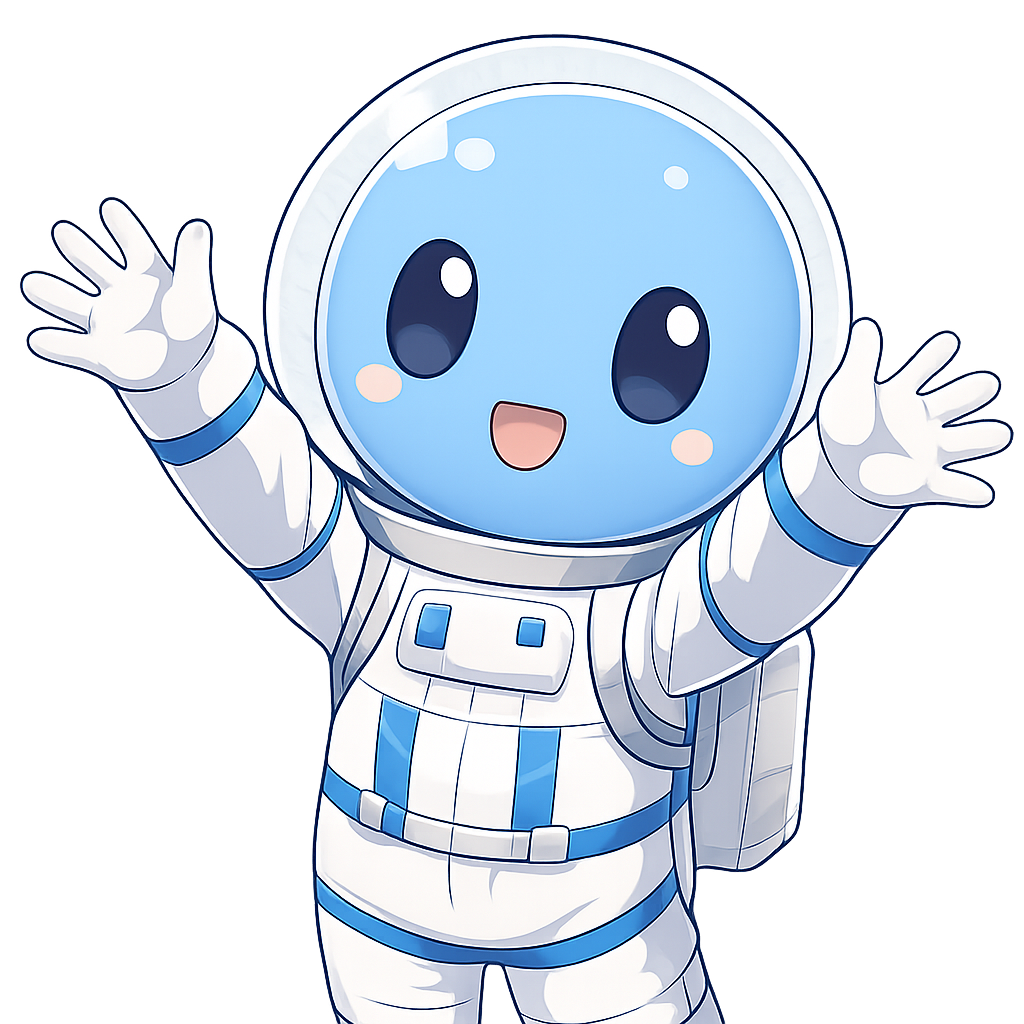

In [8]:
# Custom image generation - modify the prompt below!

CUSTOM_PROMPT = """Anime style illustration, clean line art, soft cel shading.
Transparent background.

Promptling character definition:
Small blue humanoid with oversized round head, large oval eyes, simple face, no nose.
Wears a white space suit with blue stripes, clear round helmet, small backpack.

Scene:
One Promptling waving hello with both hands.
Cheerful and welcoming pose.
"""

print("Generating custom image...")
custom_bytes = generate_image(CUSTOM_PROMPT)

if custom_bytes:
    # Save it
    custom_path = os.path.join(OUTPUT_DIR, "custom_image_1024.png")
    with open(custom_path, "wb") as f:
        f.write(custom_bytes)
    print(f"Saved to: {custom_path}")
    
    # Display it
    display_image(custom_bytes, "Custom Generated Image")
else:
    print("Generation failed")

---

## Congratulations!

You've learned how to:
- Use Microsoft Foundry's **gpt-image-1.5** model for image generation
- Generate images with **transparent backgrounds**
- Batch process multiple prompts
- Resize images for different use cases

### Next Steps
- Move to **[Step 01: Project Setup](../01-project-setup/)** to begin building your Foundry infrastructure
- Explore the [Image Prompt Engineering Guide](https://learn.microsoft.com/azure/ai-services/openai/concepts/prompt-engineering-dall-e)
- Learn about [Content Safety for Images](https://learn.microsoft.com/azure/ai-services/openai/concepts/content-filter)